### Map Projections

<img src="sphere_to_cylinder.jpeg" width=400/>

It’s impossible to flatten the Earth without distorting it in some fashion. Consider an orange peel: if you want to try and lay it flat, you have to stretch it, squash it, and tear it. Likewise with the Earth—if we want to make a map, we need to distort the Earth’s surface to flatten it. The good news is that map projections allow us to distort systematically; we know exactly how things are being stretched or squashed at any given point. We have many different map projections because each has different patterns of distortion—there is more than one way to flatten an orange peel. Some projections can even preserve certain features of the Earth without distorting them, though they can’t preserve everything. We often talk about map projections in terms of the ways in which they distort or preserve certain things about the Earth, which we call projection properties: area, form, distance, direction. 

Since there are so very many projections, the question becomes: which one should you use? As you may imagine, the fact that there are so many means there is no “best” projection. Each has advantages and disadvantages and is better suited to certain situations. https://www.axismaps.com/guide/map-projections


Cartopy is the package used for transfering data into different projections https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html. A general procedure is as follows: first, initiate new axis with prescribed __projection__ and then use regular plotting commands but add the __transform=ccrs.PlateCarree()__ to transform the lat/lon data from the PlateCarree() projection to the projection specified by the current axis. The PlateCarree() projection is the one where the (longitude,latitude) coordinates are the (x,y) coordinates of the plot.

Below we prodive a few examples of how to plot maps using the cartopy package. 

In [7]:
import matplotlib.pyplot as plt    # to make figures
import xarray as xr                # to deal with arrays in an efficient way

import cartopy.crs as ccrs         # to plot maps with different projections
import cartopy.feature as cfeature # to plot coastlines, land, borders, etc.

import numpy as np                 #for general calculations

from matplotlib.colors import LightSource


In [8]:
ERA5="ERA5_snapshot.nc"  #let's load some data.

#opening the netcdf with xarray
era = xr.open_dataset(ERA5)

#But for plotting examples we will transfer the variables back to numpy arrays
lon=era.longitude 
lat=era.latitude

u=era['u10'].data 
v=era['v10'].data

sst=era['sst'].data-273.15

Lat_Seattle=47.6062; Lon_Seattle=360-122.3321  # Seattle coordinate

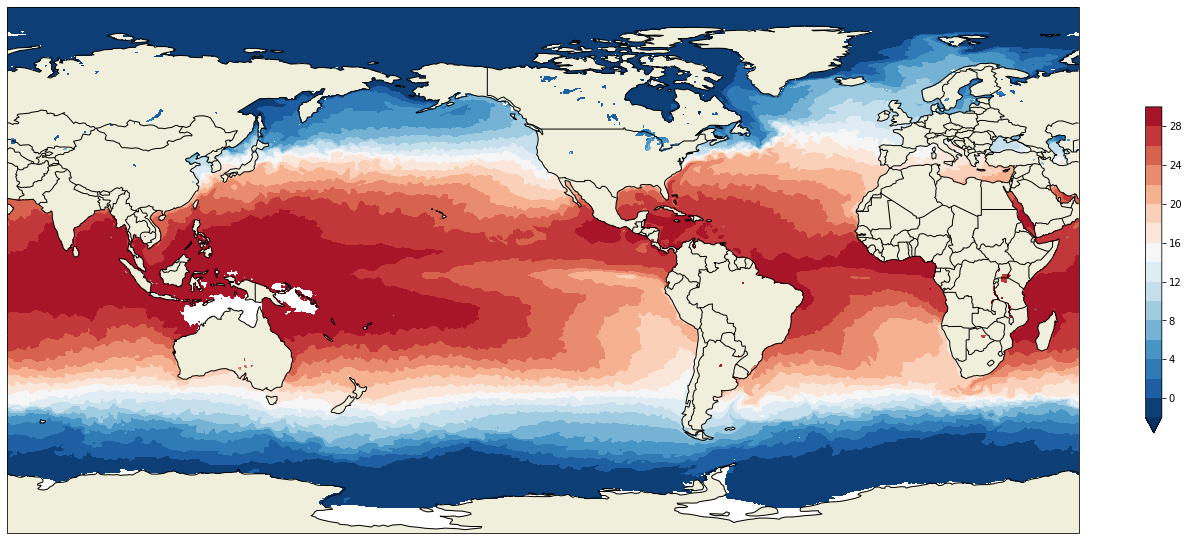

In [15]:
plt.figure(figsize=(24,12)); # this creates a figure of size (12,6) inches.
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=Lon_Seattle)) #this specifies which projection to use
im=ax.contourf(lon,lat, sst, 
                  transform=ccrs.PlateCarree(),
                  levels=np.arange(-2,32,2),extend='min',
                  cmap='RdBu_r',
                  vmin=-2, vmax=32)
plt.colorbar(im,shrink=0.5);

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.BORDERS);
#plt.savefig('SST_Winds.png')

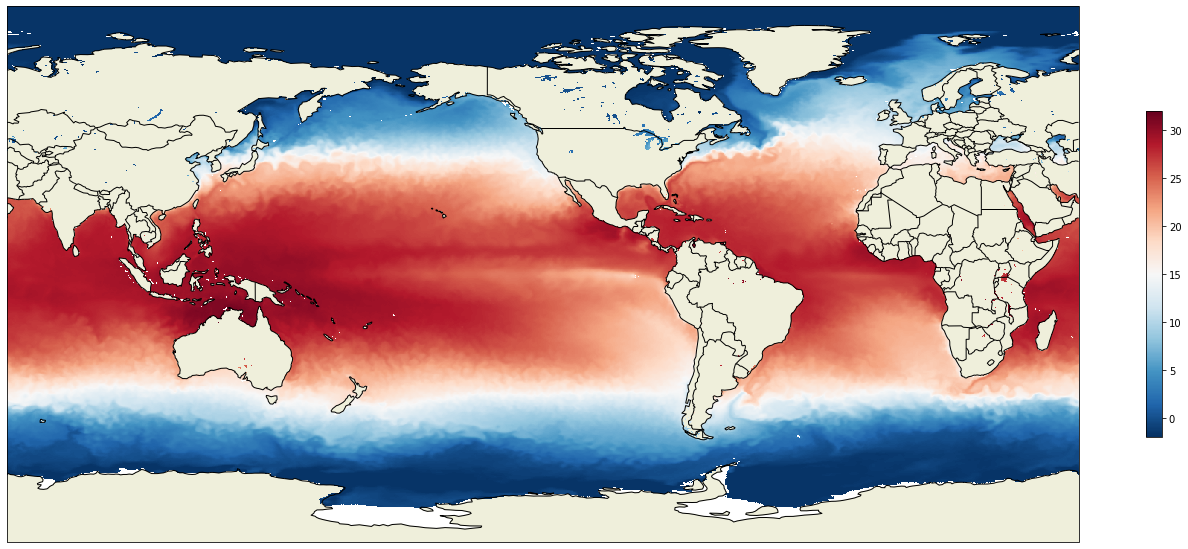

In [16]:
plt.figure(figsize=(24,12)); # this creates a figure of size (12,6) inches.
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=Lon_Seattle)) #this specifies which projection to use
im=ax.pcolormesh(lon,lat, sst, 
                  transform=ccrs.PlateCarree(),
                  cmap='RdBu_r',
                  vmin=-2, vmax=32)
plt.colorbar(im,shrink=0.5);

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.BORDERS);
#plt.savefig('SST_Winds.png')

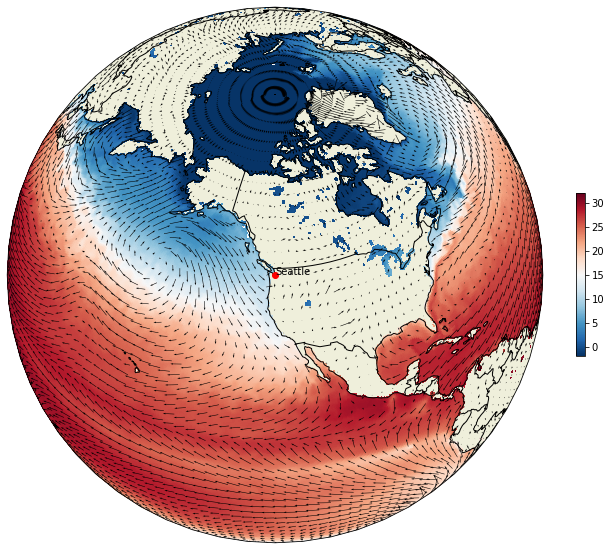

In [14]:
plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=Lon_Seattle, 
                                           central_latitude=Lat_Seattle, 
                                           globe=None))

#im=plt.contourf(lon,lat,sst, 
#                   transform=ccrs.PlateCarree(), 
#                   levels=np.arange(-2,32,2),extend='min',
#                   cmap='RdBu_r')

im=ax.pcolormesh(lon,lat, sst, 
                  transform=ccrs.PlateCarree(),
                  cmap='RdBu_r',
                  vmin=-2, vmax=32)


plt.colorbar(im,shrink=0.25)

N=10 
ax.quiver(lon[::N], lat[::N], u[::N,::N], v[::N,::N],
          transform=ccrs.PlateCarree(),
          width=0.001, 
          scale=300)

plt.title('')

plt.plot(Lon_Seattle,Lat_Seattle,      # add a red dot for Seattle location!
         marker='o',color='red',
         transform=ccrs.PlateCarree())

plt.text(Lon_Seattle,Lat_Seattle,      # add a text label
         'Seattle',
         transform=ccrs.PlateCarree())


ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.BORDERS);

# Ploting topography

In [17]:
# Load the downloaded bathymetry data into xarray
topo=xr.open_dataset('GMRTv4_0_20220724topo.grd')
dim=np.flip(topo.dimension).values
z=topo.z.values
z=z.reshape(dim)
z[np.isnan(z)]=0;

x=np.linspace(topo.x_range[0],topo.x_range[1],dim[1])
y=np.linspace(topo.y_range[1],topo.y_range[0],dim[0])

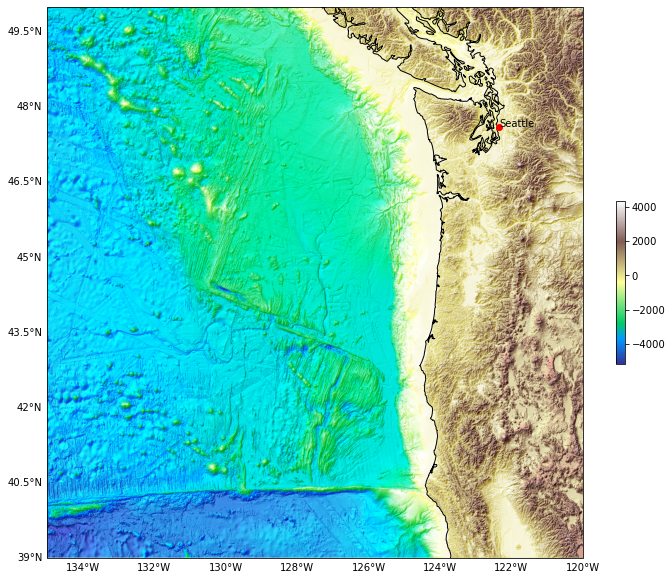

In [19]:
plt.figure(figsize=(12,12))

#specifying the colormap and its limits
cmap = plt.get_cmap('terrain') 
vmin = np.min(z) 
vmax = np.max(z)

#creating a shaded image with specified light source location
ls = LightSource(azdeg=315, altdeg=45)
z_shaded = ls.shade(z, cmap=cmap,blend_mode='overlay',vert_exag=0.1)

#set appropriate aspect ratio; otherwise, images are shown with 1:1 aspect ratio
aspect=1/np.cos(np.pi/180*np.mean(y));  # aspect ratio = 1 degree lat in km over 1degree lon in km = 1/cos(lat)

#setting a projection; the fastest is PlateCarree because that's where the lat/lon elevation data is defined 
ax = plt.axes(projection=ccrs.PlateCarree())

gl=ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xlines=None
gl.ylines=None

cax=plt.imshow(z_shaded, 
               cmap=cmap,
               vmin=vmin, vmax=vmax,
               extent=[min(x),max(x),min(y),max(y)], 
               aspect=aspect)
plt.colorbar(cax, shrink =0.25)
ax.add_feature(cfeature.COASTLINE)

plt.plot(Lon_Seattle,Lat_Seattle,      # add a red dot for Seattle location!
         marker='o',color='red',
         transform=ccrs.PlateCarree())

plt.text(Lon_Seattle,Lat_Seattle,      # add a text label
         'Seattle',
         transform=ccrs.PlateCarree());
